# Imports

In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da
import models.resnet as resnet

2024-09-11 11:40:23.313895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 11:40:23.831003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-11 11:40:23.831057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-11 11:40:23.831064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load Dataset

In [15]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Data augmentation + pair generation

In [2]:
# random ecg
random_ecg = random.choice(range(len(X_train)))
random_samp = X_train[random_ecg]

masked_ecg = mask_ecg(random_samp, mask_ratio=0.1)
lead_masked_ecg = mask_lead(random_samp, mask_ratio=0.2)

dv.plot_12_lead_ecgs([random_samp, masked_ecg, lead_masked_ecg], ['Original', 'Masked', 'Lead Masked'])

NameError: name 'X_train' is not defined

In [2]:
def mask_ecg(ecg, mask_ratio=0.1):
    block_size = 20
    
    for lead in range(ecg.shape[1]):
        for i in range(0, ecg.shape[0], block_size):
            if random.random() < mask_ratio:
                ecg[i:i+block_size, lead] = 0
    return ecg

def mask_lead(ecg, mask_ratio=0.1):

    for lead in range(ecg.shape[1]):
        if random.random() < mask_ratio:
            ecg[:, lead] = 0
    return ecg

In [3]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    # res = mask_ecg(noised_drifted_signal, mask_ratio=0.1) if random.random() < 0.5 else mask_lead(noised_drifted_signal, mask_ratio=0.2)
    res = noised_drifted_signal
    return res

def generate_augmented_pairs(batch):
    augmented_batch_1 = np.array([augment_ecg_signal(x) for x in batch])
    augmented_batch_2 = np.array([augment_ecg_signal(x) for x in batch])
    return augmented_batch_1, augmented_batch_2

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# NT-Xent loss (normalized temperature-scaled cross entropy loss)

In [5]:
def nt_xent_loss(x, temperature):
    # cosine similarity
    x_norm = tf.math.l2_normalize(x, axis=1)
    x_cos_sim = tf.matmul(x_norm, x_norm, transpose_b=True)
    
    # mask with -inf on diagonal
    mask = tf.eye(x.shape[0], dtype=tf.bool)
    x_cos_sim = tf.where(mask, -np.inf, x_cos_sim)
    
    # set targets
    samples = x.shape[0]
    target = tf.range(samples)
    target = tf.concat([target[samples//2:], target[:samples//2]], axis=0)
    # target = tf.range(samples)
    # target = tf.where(target % 2 == 0, target + 1, target - 1)
    
    # temperature scaling
    x_cos_sim /= temperature
    
    # loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=x_cos_sim, labels=target)
    loss = tf.reduce_mean(loss)
    
    return loss
    

# Model

In [4]:
# def encoder(X):
    
#     # conv1
#     X = keras.layers.Conv1D(filters=32, kernel_size=3, name='conv1', input_shape=X.shape[1:])(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation('relu')(X)
    
#     # conv2
#     X = keras.layers.Conv1D(filters=64, kernel_size=3, name='conv2')(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation('relu')(X)
    
#     # conv3
#     X = keras.layers.Conv1D(filters=128, kernel_size=3, name='conv3')(X)
#     X = keras.layers.BatchNormalization()(X)
#     X = keras.layers.Activation('relu')(X)
    
#     # global average pooling
#     X = keras.layers.GlobalAveragePooling1D()(X)
    
#     # dense
#     X = keras.layers.Dense(128, activation='relu', name='dense')(X)
    
#     return X

def projection_head(X):
    
    X = keras.layers.Dense(64, activation='relu', name='dense_proj_1')(X)
    X = keras.layers.Dense(32, name='dense_proj_2')(X)

    return X

# Build the full model (encoder + projection head)
# def build_simclr_model(input_shape):
#     representations = encoder(input_shape)
#     projections = projection_head(representations)
#     model = keras.Model(inputs=input_shape, outputs=projections)
#     return model

In [6]:
X_input = keras.Input(shape=X_.shape[1:])
model = build_simclr_model(X_input)
model.summary()

NameError: name 'X_' is not defined

# ResNet Model

In [7]:
num_classes = 5
X_input = keras.Input(shape=X_train.shape[1:])

_, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
out = projection_head(fe)


model = keras.Model(inputs=X_input, outputs=out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

NameError: name 'X_train' is not defined

#  SimCLR Training Loop

In [6]:
def train_simclr_model(model, dataset, loss_fn, optimizer, temperature=0.1, epochs=10, name='unnnamed'):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_steps = len(dataset)
        for step, x_batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                x1, x2 = generate_augmented_pairs(x_batch)
                x = tf.concat([x1, x2], axis=0)
                z = model(x)
                loss = loss_fn(z, temperature)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            if step % 100 == 0:
                print(f"Step {step}/{total_steps}, Loss {loss.numpy()}")
        model.save(f"models/{name}_epoch_{epoch + 1}.h5")

In [9]:
ecg_dataset = tf.data.Dataset.from_tensor_slices(X_train)
ecg_dataset = ecg_dataset.shuffle(buffer_size=1024).batch(32)

In [19]:
import tensorflow as tf

def mask_ecg(ecg, mask_ratio=0.1, block_size=20):
    ecg_shape = tf.shape(ecg)
    num_blocks = ecg_shape[0] // block_size
    
    mask = tf.random.uniform([num_blocks, ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.reshape(tf.tile(mask[:, None, :], [1, block_size, 1]), ecg_shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

def mask_lead(ecg, mask_ratio=0.1):
    ecg_shape = tf.shape(ecg)
    
    mask = tf.random.uniform([ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.tile(mask[None, :], [ecg_shape[0], 1])
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

In [20]:
train_simclr_model(model, ecg_dataset, nt_xent_loss, keras.optimizers.Adam(), epochs=1)

Epoch 1/1


2024-05-23 16:14:34.292570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-23 16:14:35.171980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-23 16:14:35.488326: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8e163720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 16:14:35.488349: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-23 16:14:35.491755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 16:14:35.563381: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

Step 0, Loss 3.9611167907714844
Step 100, Loss 1.8470470905303955
Step 200, Loss 1.2543076276779175
Step 300, Loss 0.898968517780304
Step 400, Loss 0.7810618281364441
Step 500, Loss 0.6800718307495117
Step 600, Loss 0.42289137840270996
Step 700, Loss 0.6297053098678589
Step 800, Loss 0.4002740979194641
Step 900, Loss 0.48334580659866333
Step 1000, Loss 0.48849689960479736
Step 1100, Loss 0.27992379665374756
Step 1200, Loss 0.4014979302883148
Step 1300, Loss 0.28724557161331177
Step 1400, Loss 0.7629520893096924
Step 1500, Loss 0.28271931409835815
Step 1600, Loss 0.22334280610084534
Step 1700, Loss 0.3432703912258148
Step 1800, Loss 0.20712673664093018
Step 1900, Loss 0.23778806626796722
Step 2000, Loss 0.31361129879951477
Step 2100, Loss 0.3605268597602844
Step 2200, Loss 0.3587362766265869
Step 2300, Loss 0.27314066886901855
Step 2400, Loss 0.4611063599586487
Step 2500, Loss 0.22081470489501953
Step 2600, Loss 0.24106033146381378
Step 2700, Loss 0.31560930609703064
Step 2800, Loss 0.1

# Save Model

In [21]:
# save keras model
model.save('resnet10_simclr_model.h5')

# TSNE Visualization of embeddings

In [11]:
# load model
model = keras.models.load_model('model-weights/simclr_model.h5')

In [16]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = [0 if "CD" in x else 1 for x in Y_train_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]


plot_tsne(model, X_train[:1000], labels=labels_Norm)
    
    
    

ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 200, 12), found shape=(1000, 100, 12)

# Finetuning

In [5]:
test_fold = 10
val_fold = 9

X_train = X_HB[np.where(Strat_og_HB <= 8)]
y_train = Z_HB[(Strat_og_HB <= 8)]
y_train_text =Z_HB_text[(Strat_og_HB <= 8)]

X_val = X_HB[np.where(Strat_og_HB == val_fold)]
y_val = Z_HB[Strat_og_HB == val_fold]

X_test = X_HB[np.where(Strat_og_HB == test_fold)]
y_test = Z_HB[Strat_og_HB == test_fold]

print('Train data shape: ', X_train.shape, 'Train labels shape: ', y_train.shape, 'Train labels text shape: ', y_train_text.shape)

Train data shape:  (204158, 200, 12) Train labels shape:  (204158, 5) Train labels text shape:  (204158,)


In [6]:
num_classes = 5

def build_classifier(X):
    X = keras.layers.Dense(32, activation='relu', name='Dense_class_1')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid', name='Dense_class_2')(X)
    return X

X_input = keras.Input(shape=X_HB.shape[1:])

enc = encoder(X_input)
classifier = build_classifier(enc)

classifier_model = keras.Model(inputs=X_input, outputs=classifier)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
classifier_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
classifier_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 198, 32)           1184      
                                                                 
 batch_normalization (BatchN  (None, 198, 32)          128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 198, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 196, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 196, 64)          256       
 hNormalization)                                             

2024-05-13 18:35:23.191996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.248714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.248923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-13 18:35:23.249391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
# load weights from simclr model by name
classifier_model.load_weights('simclr_model.h5', by_name=True)

In [8]:
batch_size = 32

train_generator = augment_ecg_signal_batch(X_train, y_train, batch_size=batch_size)

history = classifier_model.fit(train_generator, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

Epoch 1/5


2024-05-13 18:35:36.613739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-13 18:35:37.666423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-13 18:35:37.669968: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x303ad5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 18:35:37.669990: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-13 18:35:37.675372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 18:35:37.755343: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

6379/6379 [==============================] - 48s 7ms/step - loss: 0.3159 - accuracy: 0.6879 - precision: 0.7829 - recall: 0.6438 - binary_accuracy: 0.8661 - val_loss: 0.3294 - val_accuracy: 0.6784 - val_precision: 0.7741 - val_recall: 0.6457 - val_binary_accuracy: 0.8635
Epoch 2/5
6379/6379 [==============================] - 45s 7ms/step - loss: 0.2706 - accuracy: 0.7246 - precision: 0.8142 - recall: 0.7133 - binary_accuracy: 0.8874 - val_loss: 0.3117 - val_accuracy: 0.6886 - val_precision: 0.7857 - val_recall: 0.6969 - val_binary_accuracy: 0.8759
Epoch 3/5
6379/6379 [==============================] - 44s 7ms/step - loss: 0.2541 - accuracy: 0.7385 - precision: 0.8261 - recall: 0.7369 - binary_accuracy: 0.8951 - val_loss: 0.3062 - val_accuracy: 0.7150 - val_precision: 0.7927 - val_recall: 0.6930 - val_binary_accuracy: 0.8772
Epoch 4/5
6379/6379 [==============================] - 45s 7ms/step - loss: 0.2445 - accuracy: 0.7417 - precision: 0.8322 - recall: 0.7487 - binary_accuracy: 0.8990

# Finetune ResNet

In [3]:
X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 5
out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)

fine_tuned_model = keras.Model(inputs=X_input, outputs=out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
fine_tuned_model.summary()

fine_tuned_model.load_weights('model-weights/resnet10_simclr_model.h5', by_name=True)

2024-05-23 19:31:39.209055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 19:31:39.263379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 19:31:39.263582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-23 19:31:39.264050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                              

In [5]:
# freeze weights of the encoder

texts = [f"_{i}_" for i in range(1, 8)]
print(texts)

for layer in fine_tuned_model.layers:
    if any([text in layer.name for text in texts]):
        layer.trainable = False
        

['_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_']


In [13]:
# finetune the model

batch_size = 32
data_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = fine_tuned_model.fit(data_generator, epochs=5, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)


Epoch 1/5


2024-05-23 19:41:37.910766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-23 19:41:38.797599: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-23 19:41:38.801341: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x732dfc0227f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 19:41:38.801359: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-23 19:41:38.806440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 19:41:38.892397: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime 

7179/7179 [==============================] - 172s 23ms/step - loss: 0.3022 - accuracy: 0.7056 - precision: 0.7944 - recall: 0.6744 - binary_accuracy: 0.8746 - val_loss: 0.2909 - val_accuracy: 0.7026 - val_precision: 0.7863 - val_recall: 0.7129 - val_binary_accuracy: 0.8790
Epoch 2/5
7179/7179 [==============================] - 161s 22ms/step - loss: 0.2600 - accuracy: 0.7354 - precision: 0.8226 - recall: 0.7319 - binary_accuracy: 0.8932 - val_loss: 0.2827 - val_accuracy: 0.7043 - val_precision: 0.7890 - val_recall: 0.7105 - val_binary_accuracy: 0.8793
Epoch 3/5
7179/7179 [==============================] - 163s 23ms/step - loss: 0.2473 - accuracy: 0.7406 - precision: 0.8301 - recall: 0.7467 - binary_accuracy: 0.8981 - val_loss: 0.3068 - val_accuracy: 0.7184 - val_precision: 0.7800 - val_recall: 0.7164 - val_binary_accuracy: 0.8778
Epoch 4/5
7179/7179 [==============================] - 160s 22ms/step - loss: 0.2365 - accuracy: 0.7495 - precision: 0.8381 - recall: 0.7598 - binary_accuracy

NameError: name 'y_test' is not defined

In [15]:
# evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_binary_accuracy = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test Binary Accuracy: {test_binary_accuracy}, F1 Score: {2 * (test_precision * test_recall) / (test_precision + test_recall)}")


923/923 [==============================] - 5s 5ms/step - loss: 0.2914 - accuracy: 0.7125 - precision: 0.7856 - recall: 0.7176 - binary_accuracy: 0.8806
Test Loss: 0.2913939952850342, Test Accuracy: 0.7124805450439453, Test Precision: 0.785574197769165, Test Recall: 0.7175860404968262, Test Binary Accuracy: 0.8806290626525879, F1 Score: 0.7500425619878504


In [16]:
# save the model
fine_tuned_model.save('model-weights/fine_tuned_resnet10_simclr_ptbxl_model.h5')

# BARD

In [7]:
# load Data
import sys
thismodule = sys.modules[__name__]

with np.load('data/BARD.npz', allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
            
print(ecgs.shape, ecgs_HB.shape, ecgs_HB_patients.shape, ecgs_HB_samples.shape)

(717,) (15280, 100, 12) (15280,) (15280,)


In [9]:
num_classes = 5
X_input = keras.Input(shape=ecgs_HB.shape[1:])

_, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
out = projection_head(fe)


model = keras.Model(inputs=X_input, outputs=out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

2024-09-11 11:41:12.380209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:41:12.436213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:41:12.436411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-11 11:41:12.436816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                              

In [10]:
bard_dataset = tf.data.Dataset.from_tensor_slices(ecgs_HB)
bard_dataset = bard_dataset.shuffle(buffer_size=1024).batch(32)

In [11]:
train_simclr_model(model, bard_dataset, nt_xent_loss, keras.optimizers.Adam(), epochs=3, name='simclr-bard')

Epoch 1/3


2024-09-11 11:41:45.559007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-09-11 11:41:46.465101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-11 11:41:46.776959: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x92d41780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-11 11:41:46.776980: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-09-11 11:41:46.780210: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-11 11:41:46.851156: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

Step 0/478, Loss 4.394887924194336
Step 100/478, Loss 0.7869882583618164
Step 200/478, Loss 0.3101518750190735
Step 300/478, Loss 0.6426742672920227
Step 400/478, Loss 0.14509570598602295
Epoch 2/3
Step 0/478, Loss 0.3042948544025421
Step 100/478, Loss 0.15983344614505768
Step 200/478, Loss 0.30481621623039246
Step 300/478, Loss 0.1989518254995346
Step 400/478, Loss 0.19275176525115967
Epoch 3/3
Step 0/478, Loss 0.5148261785507202
Step 100/478, Loss 0.09544500708580017
Step 200/478, Loss 0.13890403509140015
Step 300/478, Loss 0.2605126202106476
Step 400/478, Loss 0.19925354421138763


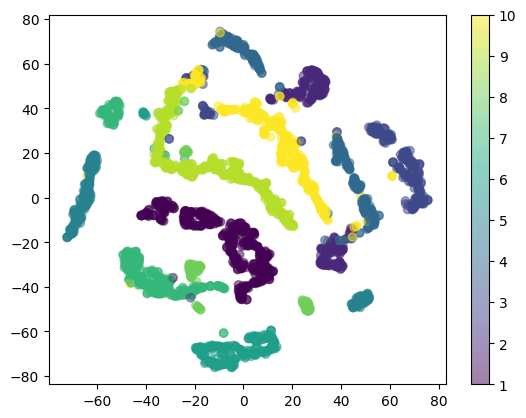

In [9]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    # show a key of colour to label
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.show()




# labels_Norm = [0 if "CD" in x else 1 for x in Y_train_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]
# labels = ecgs_HB_patients[:1000]

# get all ecgs of patinets 1-10
ecgs_HB_1_10 = ecgs_HB[np.where(ecgs_HB_patients <= 10)]
labels = ecgs_HB_patients[np.where(ecgs_HB_patients <= 10)]


# plot_tsne(model, ecgs_HB[:1000], labels=labels)
plot_tsne(model, ecgs_HB_1_10, labels=labels)

In [6]:
model = keras.models.load_model('model-weights/resnet10_simclr_bard_model.h5')

2024-06-10 17:07:48.799257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 17:07:48.943424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 17:07:48.943675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-10 17:07:48.944325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [31]:
# save model
model.save('model-weights/resnet10_simclr_bard_model.h5')

# China Pretrain 

In [7]:
# load china data

# load Data
import sys
thismodule = sys.modules[__name__]

with np.load('data/DAT_China_pretrain_1s_HB.npz', allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
            
print(X.shape, Y.shape)

(282615, 100, 12) (282615,)


In [8]:
num_classes = 5
X_input = keras.Input(shape=X.shape[1:])

_, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
out = projection_head(fe)


model = keras.Model(inputs=X_input, outputs=out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()


2024-08-01 15:07:14.249112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 15:07:14.301123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 15:07:14.301319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-01 15:07:14.301782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                              

In [9]:
china_pretrain_dataset = tf.data.Dataset.from_tensor_slices(X)
china_pretrain_dataset = china_pretrain_dataset.shuffle(buffer_size=1024).batch(32)

In [10]:
train_simclr_model(model, china_pretrain_dataset, nt_xent_loss, keras.optimizers.Adam(), epochs=5, name='resnet10_simclr_china_pretrain')

Epoch 1/5


2024-08-01 15:07:29.950311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-08-01 15:07:30.829805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-01 15:07:31.143517: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8d5a4d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-01 15:07:31.143536: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-08-01 15:07:31.146762: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 15:07:31.216697: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

Step 0/8832, Loss 3.10552978515625
Step 100/8832, Loss 1.112693428993225
Step 200/8832, Loss 0.4176478087902069
Step 300/8832, Loss 0.31776532530784607
Step 400/8832, Loss 0.33187779784202576
Step 500/8832, Loss 0.2616361379623413
Step 600/8832, Loss 0.2822117209434509
Step 700/8832, Loss 0.2160591334104538
Step 800/8832, Loss 0.12955866754055023
Step 900/8832, Loss 0.13633012771606445
Step 1000/8832, Loss 0.2024131715297699
Step 1100/8832, Loss 0.08842749893665314
Step 1200/8832, Loss 0.10878604650497437
Step 1300/8832, Loss 0.1462782770395279
Step 1400/8832, Loss 0.24397195875644684
Step 1500/8832, Loss 0.04698268324136734
Step 1600/8832, Loss 0.10634617507457733
Step 1700/8832, Loss 0.06904549896717072
Step 1800/8832, Loss 0.057665109634399414
Step 1900/8832, Loss 0.061392880976200104
Step 2000/8832, Loss 0.0718441754579544
Step 2100/8832, Loss 0.11918184906244278
Step 2200/8832, Loss 0.07180148363113403
Step 2300/8832, Loss 0.17508819699287415
Step 2400/8832, Loss 0.086155265569686

In [12]:
# shuffle data
indices = np.random.permutation(X.shape[0])

X = X[indices]
Y = Y[indices]

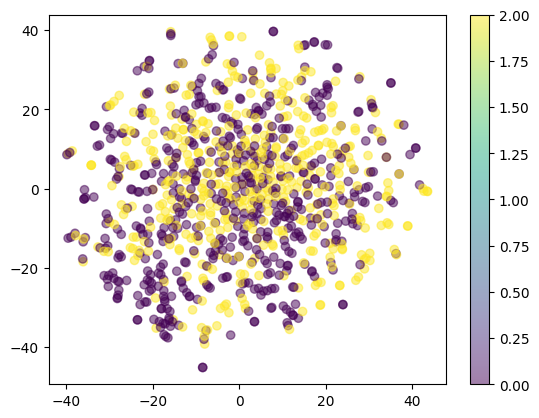

In [13]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    # show a key of colour to label
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.show()
    
    
plot_tsne(model, X[:1000], labels=Y[:1000])

# Combined Pretrain

In [6]:
# load
NP_PATH = 'data/all_pretrain_unlabelled_HB.npz'
thismodule = sys.modules[__name__]

with np.load(NP_PATH, allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
        
print(beats.shape)

(586264, 100, 12)


In [7]:
num_classes = 5
X_input = keras.Input(shape=beats.shape[1:])

_, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
out = projection_head(fe)


model = keras.Model(inputs=X_input, outputs=out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

2024-09-10 12:09:10.103856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-10 12:09:10.155649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-10 12:09:10.155844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-10 12:09:10.156390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_1[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                              

In [8]:
all_pretrain_dataset = tf.data.Dataset.from_tensor_slices(beats)
all_pretrain_dataset = all_pretrain_dataset.shuffle(buffer_size=1024).batch(32)

2024-09-10 12:09:37.358944: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5628134400 exceeds 10% of free system memory.
2024-09-10 12:09:42.482863: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5628134400 exceeds 10% of free system memory.


In [11]:
train_simclr_model(model, all_pretrain_dataset, nt_xent_loss, keras.optimizers.Adam(), epochs=10, name='resnet10_simclr_all_pretrain')

Epoch 1/10


2024-09-10 12:10:47.360062: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5628134400 exceeds 10% of free system memory.
2024-09-10 12:10:50.384729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-09-10 12:10:51.587392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-10 12:10:51.951530: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x8c66b210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-10 12:10:51.951555: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-09-10 12:10:51.962695: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 12:10:52.085237

Step 0/18321, Loss 3.8209753036499023
Step 100/18321, Loss 0.8929407000541687
Step 200/18321, Loss 0.6985041499137878
Step 300/18321, Loss 0.3998153805732727
Step 400/18321, Loss 0.3810234069824219
Step 500/18321, Loss 0.6090936660766602
Step 600/18321, Loss 0.2271704226732254
Step 700/18321, Loss 0.13074816763401031
Step 800/18321, Loss 0.09864538908004761
Step 900/18321, Loss 0.13369309902191162
Step 1000/18321, Loss 0.24319089949131012
Step 1100/18321, Loss 0.12494421750307083
Step 1200/18321, Loss 0.0876835286617279
Step 1300/18321, Loss 0.08291824162006378
Step 1400/18321, Loss 0.10442733764648438
Step 1500/18321, Loss 0.1649359166622162
Step 1600/18321, Loss 0.07229286432266235
Step 1700/18321, Loss 0.10962359607219696
Step 1800/18321, Loss 0.06058346480131149
Step 1900/18321, Loss 0.13936612010002136
Step 2000/18321, Loss 0.18665684759616852
Step 2100/18321, Loss 0.07327963411808014
Step 2200/18321, Loss 0.16004732251167297
Step 2300/18321, Loss 0.09510451555252075
Step 2400/183

KeyboardInterrupt: 